#HW5

Following the paper "Examining the feasibility of using open data to benchmark building energy usage in cities: A data science and policy perspective" [Roth et al 2019](https://www.researchgate.net/publication/337074109_Examining_the_feasibility_of_using_open_data_to_benchmark_building_energy_usage_in_cities_A_data_science_and_policy_perspective), choose 2 cities in the dataset available through the paper's github repository https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking

This paper is an excellent example of reproducible research.

I also created an example of using random forest classifier and regressors here https://github.com/fedhere/PUS2022_FBianco/blob/master/classdemo/COVID19LOS_featureExtractionRFexample.ipynb and there are links at the bottom of this notebook to useful functions and examples on the internet of applications of methods you will need to use.

1. Read the introduction to the paper and describe here (briefly) the goals of their analysis (and the analysis that you are about to reproduce). Max 200 words.
2. Choose 2 cities (any 2 cities except Seattle cause I am running some of the Seattle analysis below for guidance)
3. For each of the 2 cities reproduce their analysis by

  3.1 gathering the original data from their repository (see below for Seattle example)

  3.2 clean the data according to their data preparation scheme, including one-hot-encoding categorical variables, except to impute missing data using KNearestNeighors instead of Gibbs sampling (see below)

  3.3 run a Random Forest (RF) Regressor to predict the total energy consumption.

  3.4 evaluate the RF model performance by printing the R2 score (the default score in SKLearn RF) for training and test set (discuss)

  3.5 plot the features sorted by their importance and identify the most important features. are they consistent between the 2 cities? are they consistent with the paper's result?
4 compare the result for the 2 cities (discuss)

5. Extra credit:

  5.1 modify the target variable to a binary variable choosing the median of the variable values as the the energy threshold and predict whether the value is higher or lower than the threshold
  5.2 Run a Random Forest Classifier to predict if an observation is in the upper 50% percentile or lower 50% percentile (above or below the median threshold)
  5.3 Measure the performance of the model on training and test data
  5.4 Measure the feature importance and assess if the important feature have changed (discuss)

# choose a city and read in the data

In [1]:
import pandas as pd
import numpy as np

In [2]:
#seattle = pd.read_csv("https://raw.githubusercontent.com/Urban-Informatics-Lab/Open-Data-Benchmarking/master/Seattle/2016_Building_Energy_Benchmarking.csv")
philly = pd.read_csv("https://raw.githubusercontent.com/Urban-Informatics-Lab/Open-Data-Benchmarking/refs/heads/master/Philadelphia/philly_final.csv")

# inspect the dataframe

In [3]:
#print("there are (rows, columns) = ", (seattle.shape), "in the seattle dataframe")
print("there are (rows, columns) = ", (philly.shape), "in the philly dataframe")

there are (rows, columns) =  (1477, 41) in the philly dataframe


In [4]:
philly.columns

Index(['Unnamed: 0', 'num_buildings', 'year_built',
       'property_type_primary_epa', 'floor_area_total_SF',
       'h2o_use_allsources_KGAL', 'SALE_PR', 'SALE_TY', 'MV', 'TX_LND',
       'TX_BLDG', 'XMPT_LND', 'XMPT_BLDG', 'CAT_CD', 'ZONE', 'FRT', 'DPT',
       'TOT_AREA', 'TOP', 'GRG_TYP', 'GRG_SP', 'OFF_ST', 'VIEW_', 'STORIES',
       'EXT_COND', 'NO_RM', 'NO_BD', 'NO_BATH', 'BASMT_SQFT', 'FIRE',
       'INT_COND', 'TOT_LIV_AREA', 'building_value', 'value_per_SF',
       'electricity_use_KBTU', 'energy_star_score', 'site_eui_KBTUSF',
       'source_eui_KBTUSF', 'total_ghg_emissions_MTCO2e',
       'total_site_energy_KBTU', 'log_total_site_energy_KBTU'],
      dtype='object')

In [5]:
philly.describe()

,Unnamed: 0,num_buildings,year_built,floor_area_total_SF,h2o_use_allsources_KGAL,SALE_PR,MV,TX_LND,TX_BLDG,XMPT_LND,...,TOT_LIV_AREA,building_value,value_per_SF,electricity_use_KBTU,energy_star_score,site_eui_KBTUSF,source_eui_KBTUSF,total_ghg_emissions_MTCO2e,total_site_energy_KBTU,log_total_site_energy_KBTU
count,1477.000000,1477.000000,1477.000000,1.477000e+03,1.477000e+03,1.477000e+03,1.477000e+03,1.477000e+03,1.477000e+03,1.477000e+03,...,1.477000e+03,1.477000e+03,1477.000000,1.468000e+03,1077.000000,1477.000000,1477.000000,1477.000000,1.477000e+03,1477.000000
mean,776.241029,1.817874,1960.196344,2.275006e+05,1.028662e+04,3.660565e+06,1.659926e+07,1.472755e+06,6.406176e+06,1.504248e+06,...,1.535198e+05,1.378106e+07,76.472908,1.034643e+07,59.208914,76.384428,167.149966,1683.624712,2.129362e+07,15.873690
std,452.599418,5.974653,36.907717,5.177257e+05,7.772411e+04,1.424398e+07,2.881769e+07,3.453353e+06,1.886449e+07,6.866733e+06,...,1.976549e+05,2.514271e+07,125.973494,3.740089e+07,29.980012,56.227855,128.704973,7217.104943,1.001570e+08,1.291294
min,1.000000,1.000000,1732.000000,1.076400e+04,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,2.813500e+03,1.000000,1.200000,3.000000,9.500000,8.160000e+04,11.309585
25%,378.000000,1.000000,1929.000000,7.194500e+04,7.029000e+02,1.000000e+00,3.013900e+06,0.000000e+00,0.000000e+00,0.000000e+00,...,5.682800e+04,2.000000e+06,18.180223,1.487758e+06,37.000000,41.900000,90.200000,311.700000,3.912300e+06,15.179636
50%,776.000000,1.000000,1966.000000,1.100000e+05,2.115100e+03,4.000000e+00,7.371400e+06,2.108300e+05,4.528000e+05,0.000000e+00,...,9.009000e+04,5.340400e+06,44.386263,3.629641e+06,64.000000,64.600000,136.400000,621.500000,7.334257e+06,15.808067
75%,1173.000000,1.000000,1990.000000,2.270000e+05,5.834800e+03,1.575000e+06,1.675000e+07,1.319688e+06,4.623057e+06,9.268000e+05,...,1.722000e+05,1.322210e+07,95.764626,9.053458e+06,85.000000,94.200000,208.300000,1409.700000,1.745820e+07,16.675320
max,1554.000000,180.000000,2016.000000,1.435000e+07,2.126708e+06,1.835000e+08,2.470000e+08,3.592500e+07,2.169296e+08,1.916513e+08,...,2.215704e+06,2.169296e+08,1789.785714,1.016449e+09,100.000000,311.800000,868.300000,228210.300000,2.981930e+09,21.815837


<Axes: >

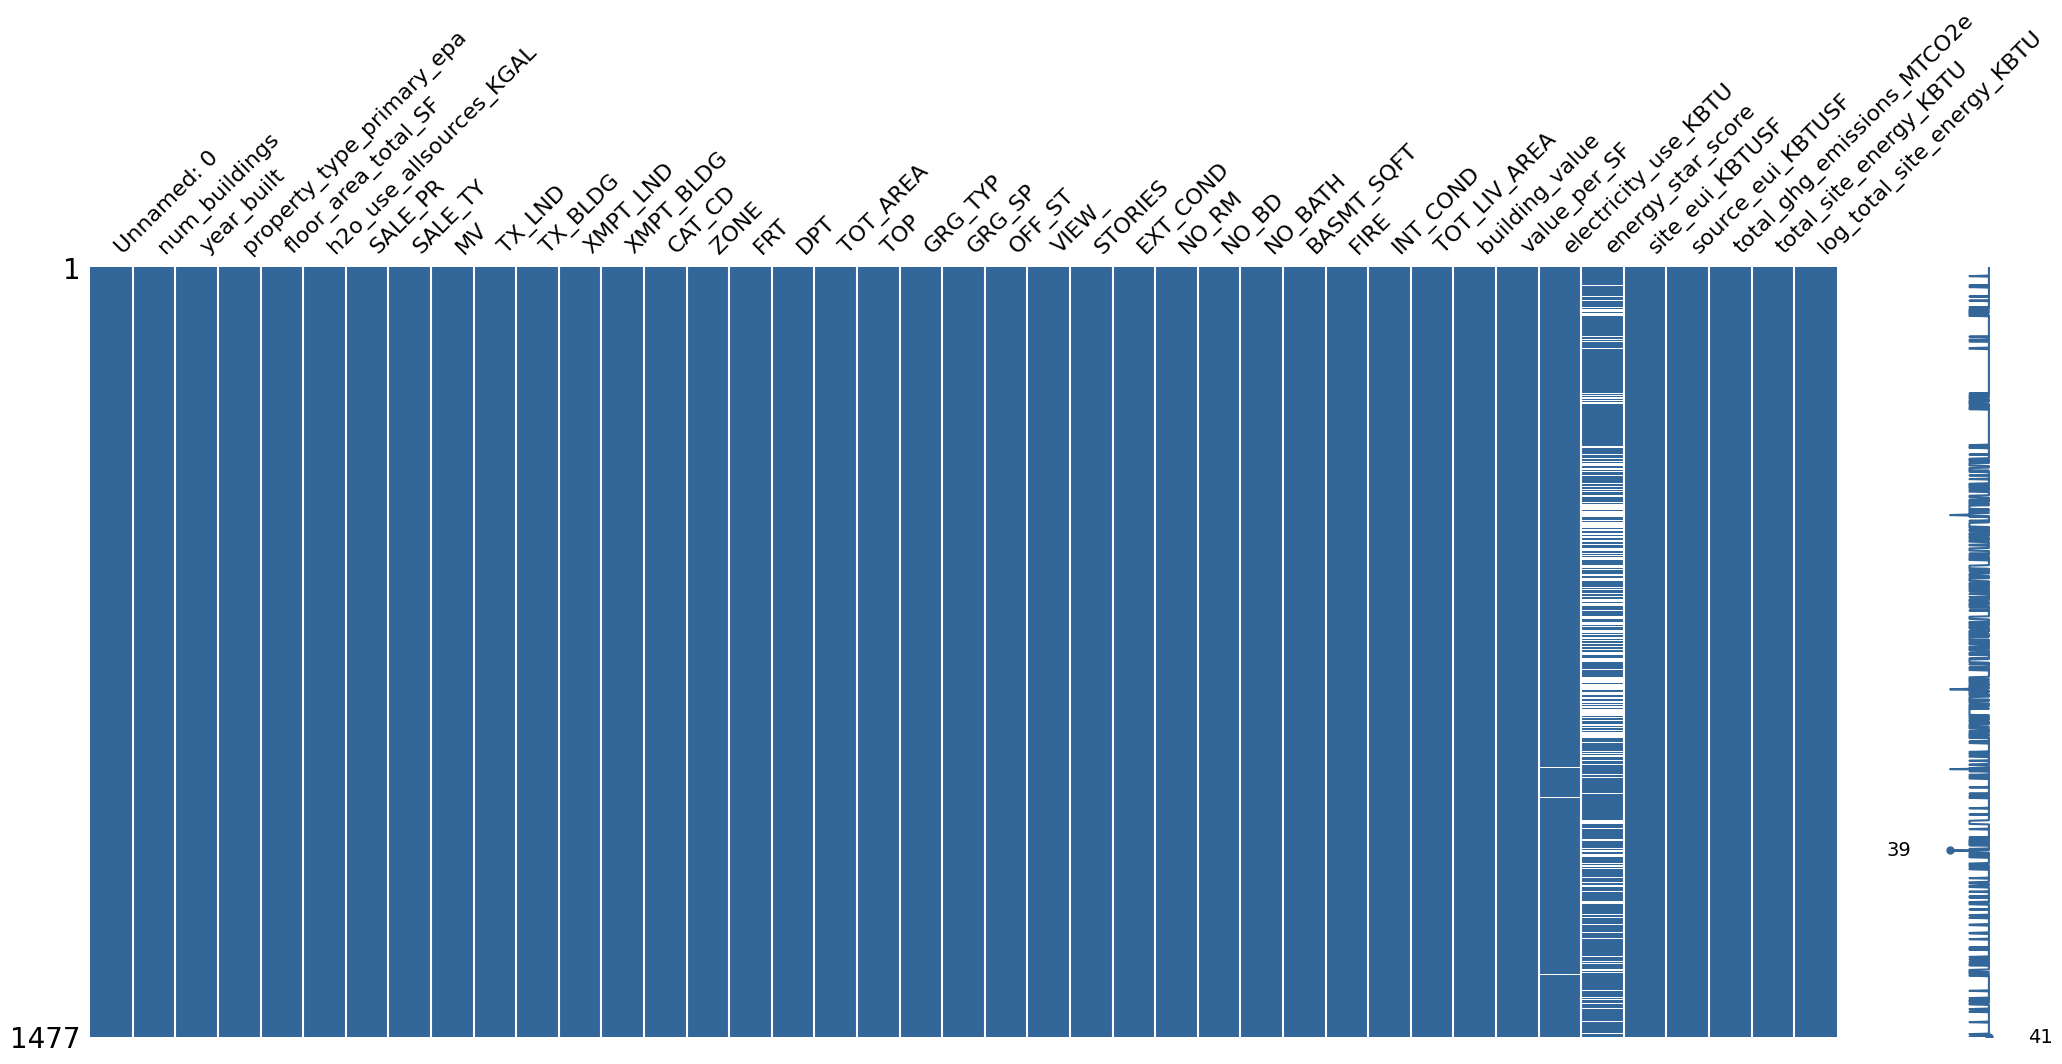

In [6]:
import missingno as msno
msno.matrix(philly, color=(0.2, 0.4, 0.6))

##Other cities

In [7]:
#boston = pd.read_csv("https://raw.githubusercontent.com/Urban-Informatics-Lab/Open-Data-Benchmarking/refs/heads/master/Boston/boston_final.csv")
#msno.matrix(boston)

In [8]:
#chicago = pd.read_csv("https://raw.githubusercontent.com/Urban-Informatics-Lab/Open-Data-Benchmarking/refs/heads/master/Chicago/chi_final.csv")
#msno.matrix(chicago)

In [9]:
#dc = pd.read_csv("https://raw.githubusercontent.com/Urban-Informatics-Lab/Open-Data-Benchmarking/refs/heads/master/DC/2016%20Energy%20and%20Water%20Performance%20Benchmarking%20Results%20as%20of%2009-07-2017.csv")
#msno.matrix(dc)

In [10]:
#la = pd.read_csv("https://raw.githubusercontent.com/Urban-Informatics-Lab/Open-Data-Benchmarking/refs/heads/master/LA/Energy_and_Water_Use_-_Municipal_Buildings.csv")
#msno.matrix(la)

# TASK 1 Clean the data
follow closely the second paragraph of Section 4 DATA. Name each step you do accordingly to the description in the paragraf
https://www.researchgate.net/publication/337074109_Examining_the_feasibility_of_using_open_data_to_benchmark_building_energy_usage_in_cities_A_data_science_and_policy_perspective

you can also help yourself inspecting the final datasets posted on the github repo but name each action according to the paper narrative: for example, if you drop "Building ID" indicate that this is done as part of
_We then cleaned the datasets by removing irrelevant building-identifying features (such as
address)_, or if dropping a variable with too many missing values _removing features that had missing values for greater than 40% of the buildings in the dataset._

In [11]:
# summarize the number of rows with missing values for each column
for c in philly.columns:

  # count number of rows with missing values
  n_miss = philly[c].isnull().sum()
  perc = n_miss / philly.shape[0] * 100
  print('%s (%s):  Missing: %d (%.1f%%)' % (c, philly[c].dtype,
                                                  n_miss, perc))


Unnamed: 0 (int64):  Missing: 0 (0.0%)
num_buildings (int64):  Missing: 0 (0.0%)
year_built (int64):  Missing: 0 (0.0%)
property_type_primary_epa (object):  Missing: 0 (0.0%)
floor_area_total_SF (float64):  Missing: 0 (0.0%)
h2o_use_allsources_KGAL (float64):  Missing: 0 (0.0%)
SALE_PR (float64):  Missing: 0 (0.0%)
SALE_TY (object):  Missing: 0 (0.0%)
MV (float64):  Missing: 0 (0.0%)
TX_LND (float64):  Missing: 0 (0.0%)
TX_BLDG (float64):  Missing: 0 (0.0%)
XMPT_LND (float64):  Missing: 0 (0.0%)
XMPT_BLDG (float64):  Missing: 0 (0.0%)
CAT_CD (int64):  Missing: 0 (0.0%)
ZONE (object):  Missing: 0 (0.0%)
FRT (float64):  Missing: 0 (0.0%)
DPT (int64):  Missing: 0 (0.0%)
TOT_AREA (float64):  Missing: 0 (0.0%)
TOP (object):  Missing: 0 (0.0%)
GRG_TYP (object):  Missing: 0 (0.0%)
GRG_SP (int64):  Missing: 0 (0.0%)
OFF_ST (int64):  Missing: 0 (0.0%)
VIEW_ (object):  Missing: 0 (0.0%)
STORIES (int64):  Missing: 0 (0.0%)
EXT_COND (int64):  Missing: 0 (0.0%)
NO_RM (int64):  Missing: 0 (0.0%)
NO_

In [12]:
#dropping irrelevant data
philly.drop(["GRG_TYP"], axis=1, inplace=True) #Garage type
philly.drop(["GRG_SP"], axis=1, inplace=True) #Separate garage
philly.drop(["VIEW_"], axis=1, inplace=True)
philly.drop(["SALE_PR"], axis=1, inplace=True) #Sale price
philly.drop(["SALE_TY"], axis=1, inplace=True) #Sale type
philly.drop(["MV"], axis=1, inplace=True) #Market value
philly.drop(["TX_LND"], axis=1, inplace=True) #Taxable land value
philly.drop(["TX_BLDG"], axis=1, inplace=True) #Taxable building value
philly.drop(["XMPT_LND"], axis=1, inplace=True) #Tax exempt land value
philly.drop(["XMPT_BLDG"], axis=1, inplace=True) #Tax exempt building value
philly.drop(["CAT_CD"], axis=1, inplace=True) #Category code
philly.drop(["Unnamed: 0"], axis=1,inplace=True)

print("there are (rows, columns) = ", (philly.shape), "in the dataframe")


there are (rows, columns) =  (1477, 29) in the dataframe


In [13]:
for c in philly.columns:

  # count number of rows with missing values
  n_miss = philly[c].isnull().sum()
  perc = n_miss / philly.shape[0] * 100
  print('%s (%s):  Missing: %d (%.1f%%)' % (c, philly[c].dtype,
                                                  n_miss, perc))

num_buildings (int64):  Missing: 0 (0.0%)
year_built (int64):  Missing: 0 (0.0%)
property_type_primary_epa (object):  Missing: 0 (0.0%)
floor_area_total_SF (float64):  Missing: 0 (0.0%)
h2o_use_allsources_KGAL (float64):  Missing: 0 (0.0%)
ZONE (object):  Missing: 0 (0.0%)
FRT (float64):  Missing: 0 (0.0%)
DPT (int64):  Missing: 0 (0.0%)
TOT_AREA (float64):  Missing: 0 (0.0%)
TOP (object):  Missing: 0 (0.0%)
OFF_ST (int64):  Missing: 0 (0.0%)
STORIES (int64):  Missing: 0 (0.0%)
EXT_COND (int64):  Missing: 0 (0.0%)
NO_RM (int64):  Missing: 0 (0.0%)
NO_BD (int64):  Missing: 0 (0.0%)
NO_BATH (int64):  Missing: 0 (0.0%)
BASMT_SQFT (float64):  Missing: 0 (0.0%)
FIRE (int64):  Missing: 0 (0.0%)
INT_COND (int64):  Missing: 0 (0.0%)
TOT_LIV_AREA (float64):  Missing: 0 (0.0%)
building_value (float64):  Missing: 0 (0.0%)
value_per_SF (float64):  Missing: 0 (0.0%)
electricity_use_KBTU (float64):  Missing: 9 (0.6%)
energy_star_score (float64):  Missing: 400 (27.1%)
site_eui_KBTUSF (float64):  Miss

# TASK 2: transform input feature as needed
for example replace features with log features. Guide yourself with the text, the final dataset names, and also the code here https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/Lasso_RandomForest.Rmd

In [14]:
philly.describe() #what should you look at in the result below?

,num_buildings,year_built,floor_area_total_SF,h2o_use_allsources_KGAL,FRT,DPT,TOT_AREA,OFF_ST,STORIES,EXT_COND,...,TOT_LIV_AREA,building_value,value_per_SF,electricity_use_KBTU,energy_star_score,site_eui_KBTUSF,source_eui_KBTUSF,total_ghg_emissions_MTCO2e,total_site_energy_KBTU,log_total_site_energy_KBTU
count,1477.000000,1477.000000,1.477000e+03,1.477000e+03,1.477000e+03,1.477000e+03,1.477000e+03,1477.000000,1477.000000,1477.000000,...,1.477000e+03,1.477000e+03,1477.000000,1.468000e+03,1077.000000,1477.000000,1477.000000,1477.000000,1.477000e+03,1477.000000
mean,1.817874,1960.196344,2.275006e+05,1.028662e+04,8.347316e+05,1.568324e+05,3.426458e+07,2.937712,39.309411,3.227488,...,1.535198e+05,1.378106e+07,76.472908,1.034643e+07,59.208914,76.384428,167.149966,1683.624712,2.129362e+07,15.873690
std,5.974653,36.907717,5.177257e+05,7.772411e+04,1.195485e+07,1.909785e+06,5.492829e+08,12.073742,67.033774,1.324555,...,1.976549e+05,2.514271e+07,125.973494,3.740089e+07,29.980012,56.227855,128.704973,7217.104943,1.001570e+08,1.291294
min,1.000000,1732.000000,1.076400e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,2.813500e+03,1.000000,1.200000,3.000000,9.500000,8.160000e+04,11.309585
25%,1.000000,1929.000000,7.194500e+04,7.029000e+02,1.178300e+04,1.425000e+04,2.587500e+06,0.000000,0.000000,3.000000,...,5.682800e+04,2.000000e+06,18.180223,1.487758e+06,37.000000,41.900000,90.200000,311.700000,3.912300e+06,15.179636
50%,1.000000,1966.000000,1.100000e+05,2.115100e+03,2.290000e+04,2.413500e+04,7.155000e+06,0.000000,10.000000,4.000000,...,9.009000e+04,5.340400e+06,44.386263,3.629641e+06,64.000000,64.600000,136.400000,621.500000,7.334257e+06,15.808067
75%,1.000000,1990.000000,2.270000e+05,5.834800e+03,4.105500e+04,4.280000e+04,1.960200e+07,0.000000,40.000000,4.000000,...,1.722000e+05,1.322210e+07,95.764626,9.053458e+06,85.000000,94.200000,208.300000,1409.700000,1.745820e+07,16.675320
max,180.000000,2016.000000,1.435000e+07,2.126708e+06,4.197360e+08,5.589920e+07,2.076941e+10,97.000000,610.000000,6.000000,...,2.215704e+06,2.169296e+08,1789.785714,1.016449e+09,100.000000,311.800000,868.300000,228210.300000,2.981930e+09,21.815837


In [15]:
philly.info() #why is this helpful to print?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   num_buildings               1477 non-null   int64  
 1   year_built                  1477 non-null   int64  
 2   property_type_primary_epa   1477 non-null   object 
 3   floor_area_total_SF         1477 non-null   float64
 4   h2o_use_allsources_KGAL     1477 non-null   float64
 5   ZONE                        1477 non-null   object 
 6   FRT                         1477 non-null   float64
 7   DPT                         1477 non-null   int64  
 8   TOT_AREA                    1477 non-null   float64
 9   TOP                         1477 non-null   object 
 10  OFF_ST                      1477 non-null   int64  
 11  STORIES                     1477 non-null   int64  
 12  EXT_COND                    1477 non-null   int64  
 13  NO_RM                       1477 

## Throw away data where the **target** variable is missing

I will remove each row where I do not have the target variable. To do that I use `df.dropna()` and the subset argument of `df.dropna()` set to the name of the variable. The `how` should be set to "any" cause you want to drop the row where any values in the subset is NaN (this is a subset of one column, so it is obvious, but imagine if you were passing more than one column to the call `dropna()`

In [16]:
philly["electricity_use_KBTU"].isna().sum()

9

In [17]:
original_len = philly.shape[0]
philly.dropna(subset=['electricity_use_KBTU'], inplace = True) #, ... #... # replace ... with your code

print("I lost {:.2f}% of the data".format((1 - (philly.shape[0] / original_len)) * 100))

I lost 0.61% of the data


<Axes: >

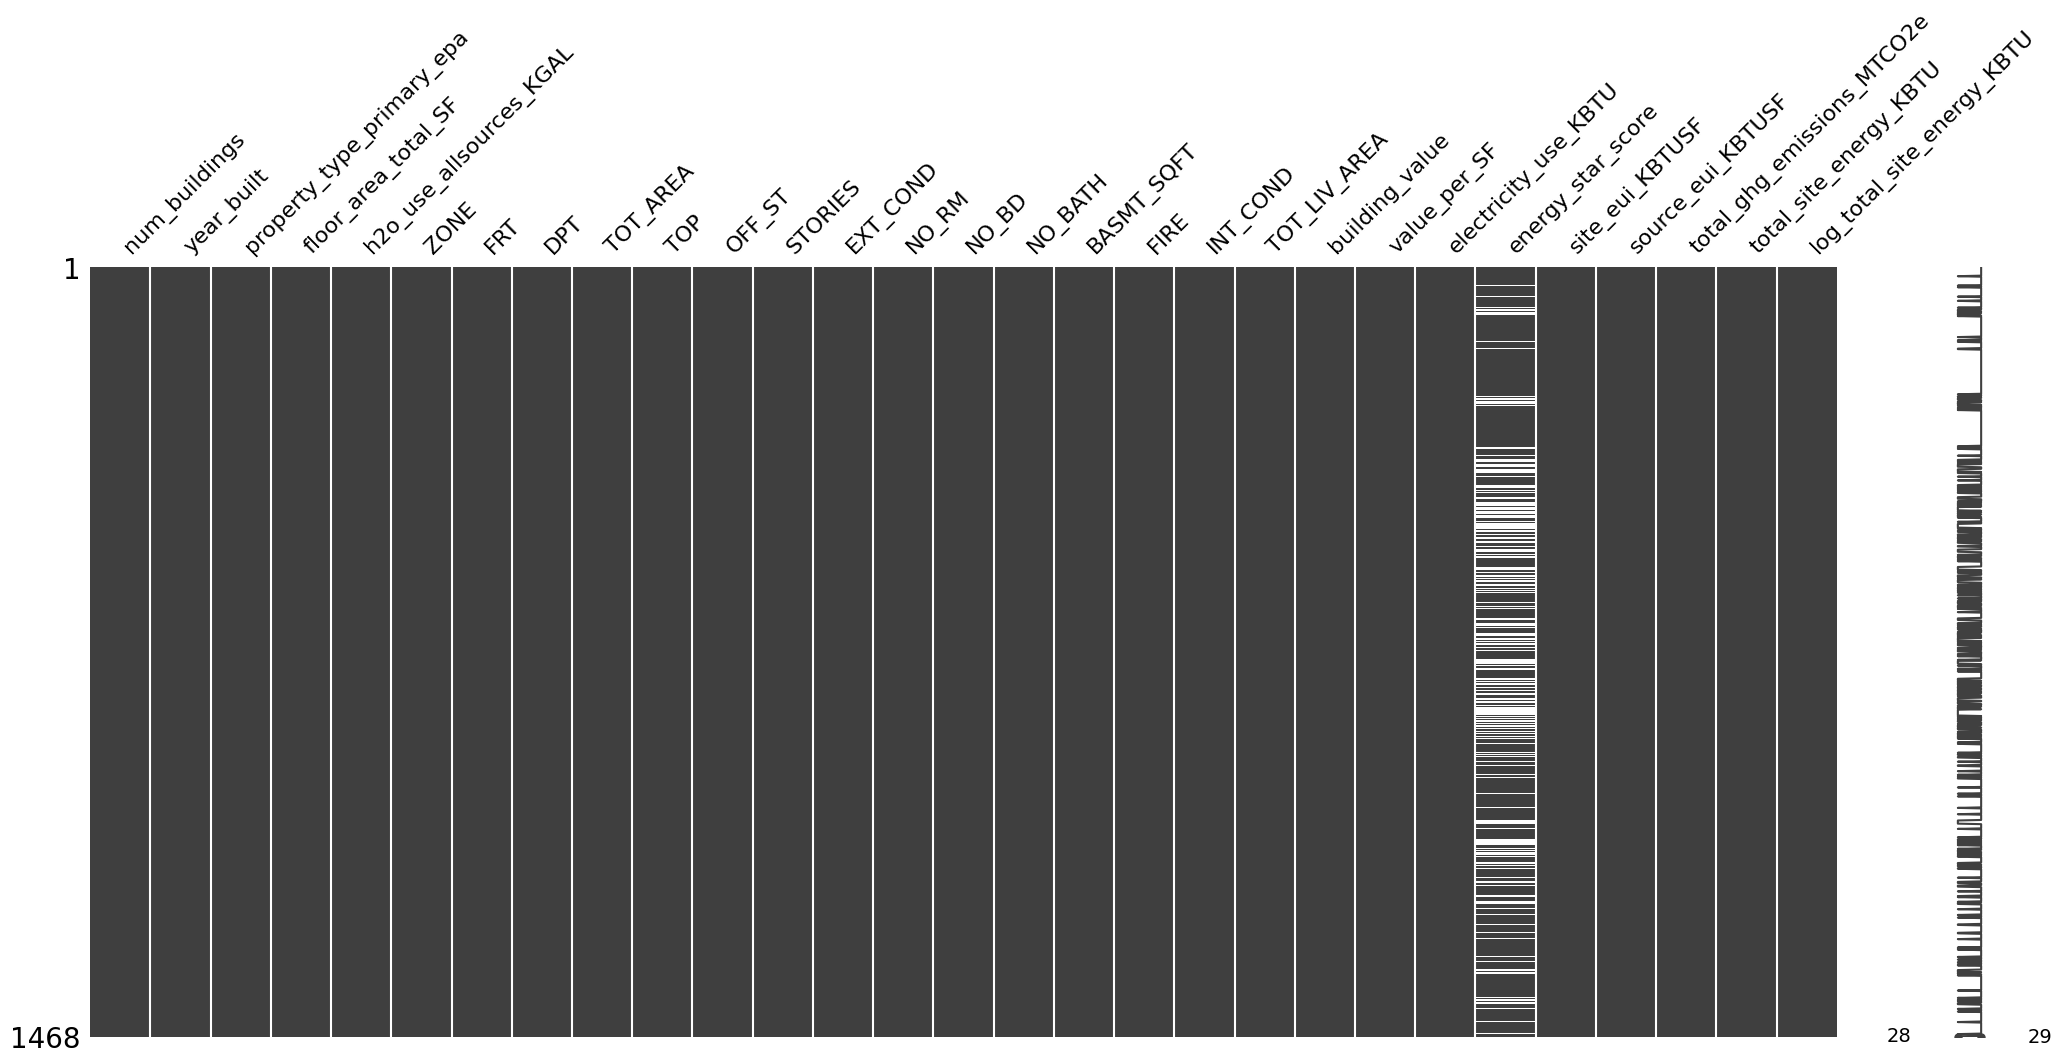

In [18]:
msno.matrix(philly)

In [19]:
# isolate the target variable first (endogenous)
y = philly['electricity_use_KBTU'].values

In [20]:
# and the input variables (exogenous)
X = philly.drop('electricity_use_KBTU', axis=1)

In [21]:
philly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1468 entries, 0 to 1476
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   num_buildings               1468 non-null   int64  
 1   year_built                  1468 non-null   int64  
 2   property_type_primary_epa   1468 non-null   object 
 3   floor_area_total_SF         1468 non-null   float64
 4   h2o_use_allsources_KGAL     1468 non-null   float64
 5   ZONE                        1468 non-null   object 
 6   FRT                         1468 non-null   float64
 7   DPT                         1468 non-null   int64  
 8   TOT_AREA                    1468 non-null   float64
 9   TOP                         1468 non-null   object 
 10  OFF_ST                      1468 non-null   int64  
 11  STORIES                     1468 non-null   int64  
 12  EXT_COND                    1468 non-null   int64  
 13  NO_RM                       1468 non-n

### separate categorical and numerical values
you will proceed to missing data imputation differently in the 2 cases

In [22]:
# I am giving you the solution but please take note of how one does this!
X_numeric_data = X.select_dtypes(include=[np.number])
X_categorical_data = X.select_dtypes(exclude=[np.number])

In [23]:
X_numeric_data.shape

(1468, 25)

In [24]:
X_numeric_data.head() ## is there anything suspicious? anything thas is in fact **not** a numerical variable? that will depend on how you did in TASK 1

,num_buildings,year_built,floor_area_total_SF,h2o_use_allsources_KGAL,FRT,DPT,TOT_AREA,OFF_ST,STORIES,EXT_COND,...,INT_COND,TOT_LIV_AREA,building_value,value_per_SF,energy_star_score,site_eui_KBTUSF,source_eui_KBTUSF,total_ghg_emissions_MTCO2e,total_site_energy_KBTU,log_total_site_energy_KBTU
0,1,1987,1117466.0,17093.4,22812.0,28400,6478600.0,0,400,4,...,4,1152520.0,158795800.0,142.103473,83.0,72.4,227.5,8491.0,80904538.4,18.208780
1,1,1992,1148906.0,16707.4,22687.0,28400,6443100.0,0,0,4,...,4,1152480.0,150772400.0,131.231276,83.0,64.4,202.3,8041.2,73989546.4,18.119434
2,1,1986,751503.0,11007.6,19600.0,18000,3528000.0,0,290,4,...,4,799994.0,89667800.0,119.317953,85.0,70.7,190.5,5028.1,53131262.1,17.788276
3,1,1981,721408.0,3428.9,20000.0,18000,3600000.0,0,270,4,...,4,708750.0,82235800.0,113.993468,88.0,62.8,175.2,4798.9,45304422.4,17.628915
4,1,1973,1178691.0,17363.1,20100.0,17600,3537600.0,0,400,0,...,0,1143040.0,159387200.0,135.223905,95.0,52.3,126.9,5008.6,61645539.3,17.936911


In [25]:
X_categorical_data.shape

(1468, 3)

In [26]:
X_categorical_data.columns

Index(['property_type_primary_epa', 'ZONE', 'TOP'], dtype='object')

## TASK 2.1: make a scatter plot to assess covariance of numerical variables

### IMPORTANT!!

there are going to be some **very** collinear variable - zoom in and chek them out - what are they? You will need to remove variables that are _identical_, because you obviously do not want to imput the data twice in the model - it will not improve the model and it will impact the feature importance analysis.

What else looks like it should be removed?

**Reason about it and explain your choices in the caption of the figure**



In [27]:
'''# THIS TAKES A LOOOONG TIME! ~10 MINUTES ON COLAB FOR ME
import seaborn as sns
sns.pairplot(X_numeric_data)
# DELETE OUTPUT!'''

'# THIS TAKES A LOOOONG TIME! ~10 MINUTES ON COLAB FOR ME\nimport seaborn as sns\nsns.pairplot(X_numeric_data)\n# DELETE OUTPUT!'

In [28]:
# which rows should you drop?
#X_numeric_data.drop(["EXT_COND"], axis=1) #... # replace ... with your code


In [29]:
X_numeric_data.describe()

,num_buildings,year_built,floor_area_total_SF,h2o_use_allsources_KGAL,FRT,DPT,TOT_AREA,OFF_ST,STORIES,EXT_COND,...,INT_COND,TOT_LIV_AREA,building_value,value_per_SF,energy_star_score,site_eui_KBTUSF,source_eui_KBTUSF,total_ghg_emissions_MTCO2e,total_site_energy_KBTU,log_total_site_energy_KBTU
count,1468.000000,1468.000000,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03,1468.000000,1468.000000,1468.000000,...,1468.000000,1.468000e+03,1.468000e+03,1468.000000,1072.000000,1468.000000,1468.000000,1468.000000,1.468000e+03,1468.000000
mean,1.818801,1960.244550,2.282481e+05,1.031169e+04,8.396723e+05,1.576603e+05,3.439641e+07,2.955722,39.407357,3.224114,...,3.252725,1.539214e+05,1.381631e+07,76.377823,59.064366,76.501839,167.750613,1691.753065,2.138944e+07,15.879622
std,5.992144,36.879686,5.192114e+05,7.795932e+04,1.199130e+07,1.915605e+06,5.509618e+08,12.108522,67.213171,1.326996,...,1.304190,1.981663e+05,2.517041e+07,125.107469,29.963011,56.232944,128.780755,7238.399567,1.004554e+08,1.289172
min,1.000000,1732.000000,1.076400e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,1.200000,3.000000,9.500000,8.160000e+04,11.309585
25%,1.000000,1929.000000,7.188025e+04,7.027750e+02,1.176225e+04,1.425000e+04,2.587271e+06,0.000000,0.000000,3.000000,...,3.000000,5.676825e+04,2.067306e+06,18.432386,37.000000,42.100000,90.400000,312.775000,3.919266e+06,15.181415
50%,1.000000,1966.000000,1.100000e+05,2.116950e+03,2.285950e+04,2.416750e+04,7.155000e+06,0.000000,10.000000,4.000000,...,4.000000,9.053200e+04,5.393420e+06,44.820572,64.000000,64.650000,136.600000,623.950000,7.336443e+06,15.808365
75%,1.000000,1990.000000,2.302198e+05,5.832475e+03,4.105500e+04,4.295150e+04,1.961172e+07,0.000000,40.000000,4.000000,...,4.000000,1.728425e+05,1.324655e+07,95.991561,85.000000,94.125000,208.525000,1415.775000,1.761945e+07,16.684513
max,180.000000,2016.000000,1.435000e+07,2.126708e+06,4.197360e+08,5.589920e+07,2.076941e+10,97.000000,610.000000,6.000000,...,6.000000,2.215704e+06,2.169296e+08,1789.785714,100.000000,311.800000,868.300000,228210.300000,2.981930e+09,21.815837


In [30]:
# this does not have to be identical to my output as you may have dropped different variables
print("there are (rows, columns) = ", X_numeric_data.shape, "in the numerical variables")

there are (rows, columns) =  (1468, 25) in the numerical variables


As they do in the original research https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/Lasso_RandomForest.Rmd we should transform some variables into their log values

their original code (which is in R not in python!) is
```
x_seattle$log_total_area=log(x_seattle$gross_floor_area_total_SF)
x_seattle$log_parking_area=log(x_seattle$gross_floor_area_parking_SF)
x_seattle$log_bldg_area=log(x_seattle$gross_floor_area_building_SF)
x_seattle$log_area_1=log(x_seattle$gross_floor_area_property_type_first_SF)

```
the names are a bit different


In [31]:
X_numeric_data.columns

Index(['num_buildings', 'year_built', 'floor_area_total_SF',
       'h2o_use_allsources_KGAL', 'FRT', 'DPT', 'TOT_AREA', 'OFF_ST',
       'STORIES', 'EXT_COND', 'NO_RM', 'NO_BD', 'NO_BATH', 'BASMT_SQFT',
       'FIRE', 'INT_COND', 'TOT_LIV_AREA', 'building_value', 'value_per_SF',
       'energy_star_score', 'site_eui_KBTUSF', 'source_eui_KBTUSF',
       'total_ghg_emissions_MTCO2e', 'total_site_energy_KBTU',
       'log_total_site_energy_KBTU'],
      dtype='object')

In [32]:
# note: recheck missing values
# this is important: after I apply the log function to some variables cause log(0) = -infinity
print("there are {} missing or infinity values in the numerical data".format(X_numeric_data.isnull().sum().sum()))

there are 396 missing or infinity values in the numerical data


In [33]:
# translated to python
X_numeric_data["total_site_energy_KBTU"] = np.log10(X_numeric_data["total_site_energy_KBTU"])
X_numeric_data.rename(columns={'total_site_energy_KBTU': 'log10_total_site_energy_KBTU'}, inplace=True)
X_numeric_data.rename(columns={'log_total_site_energy_KBTU': 'ln_total_site_energy_KBTU'}, inplace=True)

X_numeric_data["total_ghg_emissions_MTCO2e"] = np.log10(X_numeric_data["total_ghg_emissions_MTCO2e"])
X_numeric_data.rename(columns={'total_ghg_emissions_MTCO2e': 'log10_total_ghg_emissions_MTCO2e'}, inplace=True)

X_numeric_data["floor_area_total_SF"] = np.log10(X_numeric_data["floor_area_total_SF"])
X_numeric_data.rename(columns={'floor_area_total_SF': 'log10_floor_area_total_SF'}, inplace=True)

X_numeric_data["TOT_AREA"] = np.log10(X_numeric_data["TOT_AREA"])
X_numeric_data.rename(columns={'TOT_AREA': 'log10_TOT_AREA'}, inplace=True)

X_numeric_data["building_value"] = np.log10(X_numeric_data["building_value"])
X_numeric_data.rename(columns={'building_value': 'log10_building_value'}, inplace=True)

X_numeric_data["h2o_use_allsources_KGAL"] = np.log10(X_numeric_data["h2o_use_allsources_KGAL"])
X_numeric_data.rename(columns={'h2o_use_allsources_KGAL': 'log10_h2o_use_allsources_KGAL'}, inplace=True)

X_numeric_data["BASMT_SQFT"] = np.log10(X_numeric_data["BASMT_SQFT"])
X_numeric_data.rename(columns={'BASMT_SQFT': 'log10_BASMT_SQFT'}, inplace=True)

X_numeric_data["TOT_LIV_AREA"] = np.log10(X_numeric_data["TOT_LIV_AREA"])
X_numeric_data.rename(columns={'TOT_LIV_AREA': 'log10_TOT_LIV_AREA'}, inplace=True)

#replace ... with your code

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [34]:
X_numeric_data.head()

,num_buildings,year_built,log10_floor_area_total_SF,log10_h2o_use_allsources_KGAL,FRT,DPT,log10_TOT_AREA,OFF_ST,STORIES,EXT_COND,...,INT_COND,log10_TOT_LIV_AREA,log10_building_value,value_per_SF,energy_star_score,site_eui_KBTUSF,source_eui_KBTUSF,log10_total_ghg_emissions_MTCO2e,log10_total_site_energy_KBTU,ln_total_site_energy_KBTU
0,1,1987,6.048234,4.232828,22812.0,28400,6.811481,0,400,4,...,4,6.061648,8.200839,142.103473,83.0,72.4,227.5,3.928959,7.907973,18.208780
1,1,1992,6.060284,4.222909,22687.0,28400,6.809095,0,0,4,...,4,6.061633,8.178322,131.231276,83.0,64.4,202.3,3.905321,7.869170,18.119434
2,1,1986,5.875931,4.041693,19600.0,18000,6.547529,0,290,4,...,4,5.903087,7.952637,119.317953,85.0,70.7,190.5,3.701404,7.725350,17.788276
3,1,1981,5.858181,3.535155,20000.0,18000,6.556303,0,270,4,...,4,5.850493,7.915061,113.993468,88.0,62.8,175.2,3.681142,7.656141,17.628915
4,1,1973,6.071400,4.239627,20100.0,17600,6.548709,0,400,0,...,0,6.058061,8.202453,135.223905,95.0,52.3,126.9,3.699716,7.789902,17.936911


In [35]:
print("number of infinite values:", (np.isinf(X_numeric_data)).sum().sum())

number of infinite values: 1642


check what happened to missing values: they may have grown! because  log(0) = -infinity - fix infinities replacing them with NaN

(in in https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/Lasso_RandomForest.Rmd they had replaced them with 0 but I object to that)

In [36]:
# this has to return 0 now
X_numeric_data.replace(-np.inf, np.nan, inplace=True)
print("number of infinite values:", (np.isinf(X_numeric_data)).sum().sum())

number of infinite values: 0


In [37]:
print("the numerical data contains (rows, columns) = ", X_numeric_data.shape)
print("there are {} missing values in the numerical data".format(X_numeric_data.isnull().sum().sum()))

the numerical data contains (rows, columns) =  (1468, 25)
there are 2038 missing values in the numerical data



you can use `KNNImputer` on the numerical variables, but KNNImputer would fail on categorical variables so you are left with NaNs on categorical variables, which you then need to drop before you run the Random Forest


You can impute separately the numerical and categorical variables, the numerical ones with KNNImputer and the categorical ones with SimpleImputer

## TASK 2.2 use Nearest Neighbor Imputer to impute missing values in numerical features

here we are deviating from the paper. NN imputation is simpler and more common, I think it may be more useful to you in general

In [38]:
from sklearn.impute import KNNImputer

imputer = KNNImputer() #replace ... with your code
Xn = imputer.fit_transform(X_numeric_data)
Xn

array([[1.00000000e+00, 1.98700000e+03, 6.04823432e+00, ...,
        3.92895884e+00, 7.90797288e+00, 1.82087805e+01],
       [1.00000000e+00, 1.99200000e+03, 6.06028450e+00, ...,
        3.90532086e+00, 7.86917036e+00, 1.81194344e+01],
       [1.00000000e+00, 1.98600000e+03, 5.87593072e+00, ...,
        3.70140391e+00, 7.72535013e+00, 1.77882761e+01],
       ...,
       [1.00000000e+00, 1.93100000e+03, 5.07534984e+00, ...,
        2.40671046e+00, 6.36315157e+00, 1.46516980e+01],
       [1.00000000e+00, 1.95900000e+03, 5.36548798e+00, ...,
        3.35195083e+00, 7.43920634e+00, 1.71294056e+01],
       [7.00000000e+00, 2.01000000e+03, 5.64745437e+00, ...,
        3.19777661e+00, 7.13881606e+00, 1.64377314e+01]])

In [39]:
Xn_col = X_numeric_data.columns
Xn_col

Index(['num_buildings', 'year_built', 'log10_floor_area_total_SF',
       'log10_h2o_use_allsources_KGAL', 'FRT', 'DPT', 'log10_TOT_AREA',
       'OFF_ST', 'STORIES', 'EXT_COND', 'NO_RM', 'NO_BD', 'NO_BATH',
       'log10_BASMT_SQFT', 'FIRE', 'INT_COND', 'log10_TOT_LIV_AREA',
       'log10_building_value', 'value_per_SF', 'energy_star_score',
       'site_eui_KBTUSF', 'source_eui_KBTUSF',
       'log10_total_ghg_emissions_MTCO2e', 'log10_total_site_energy_KBTU',
       'ln_total_site_energy_KBTU'],
      dtype='object')

<Axes: >

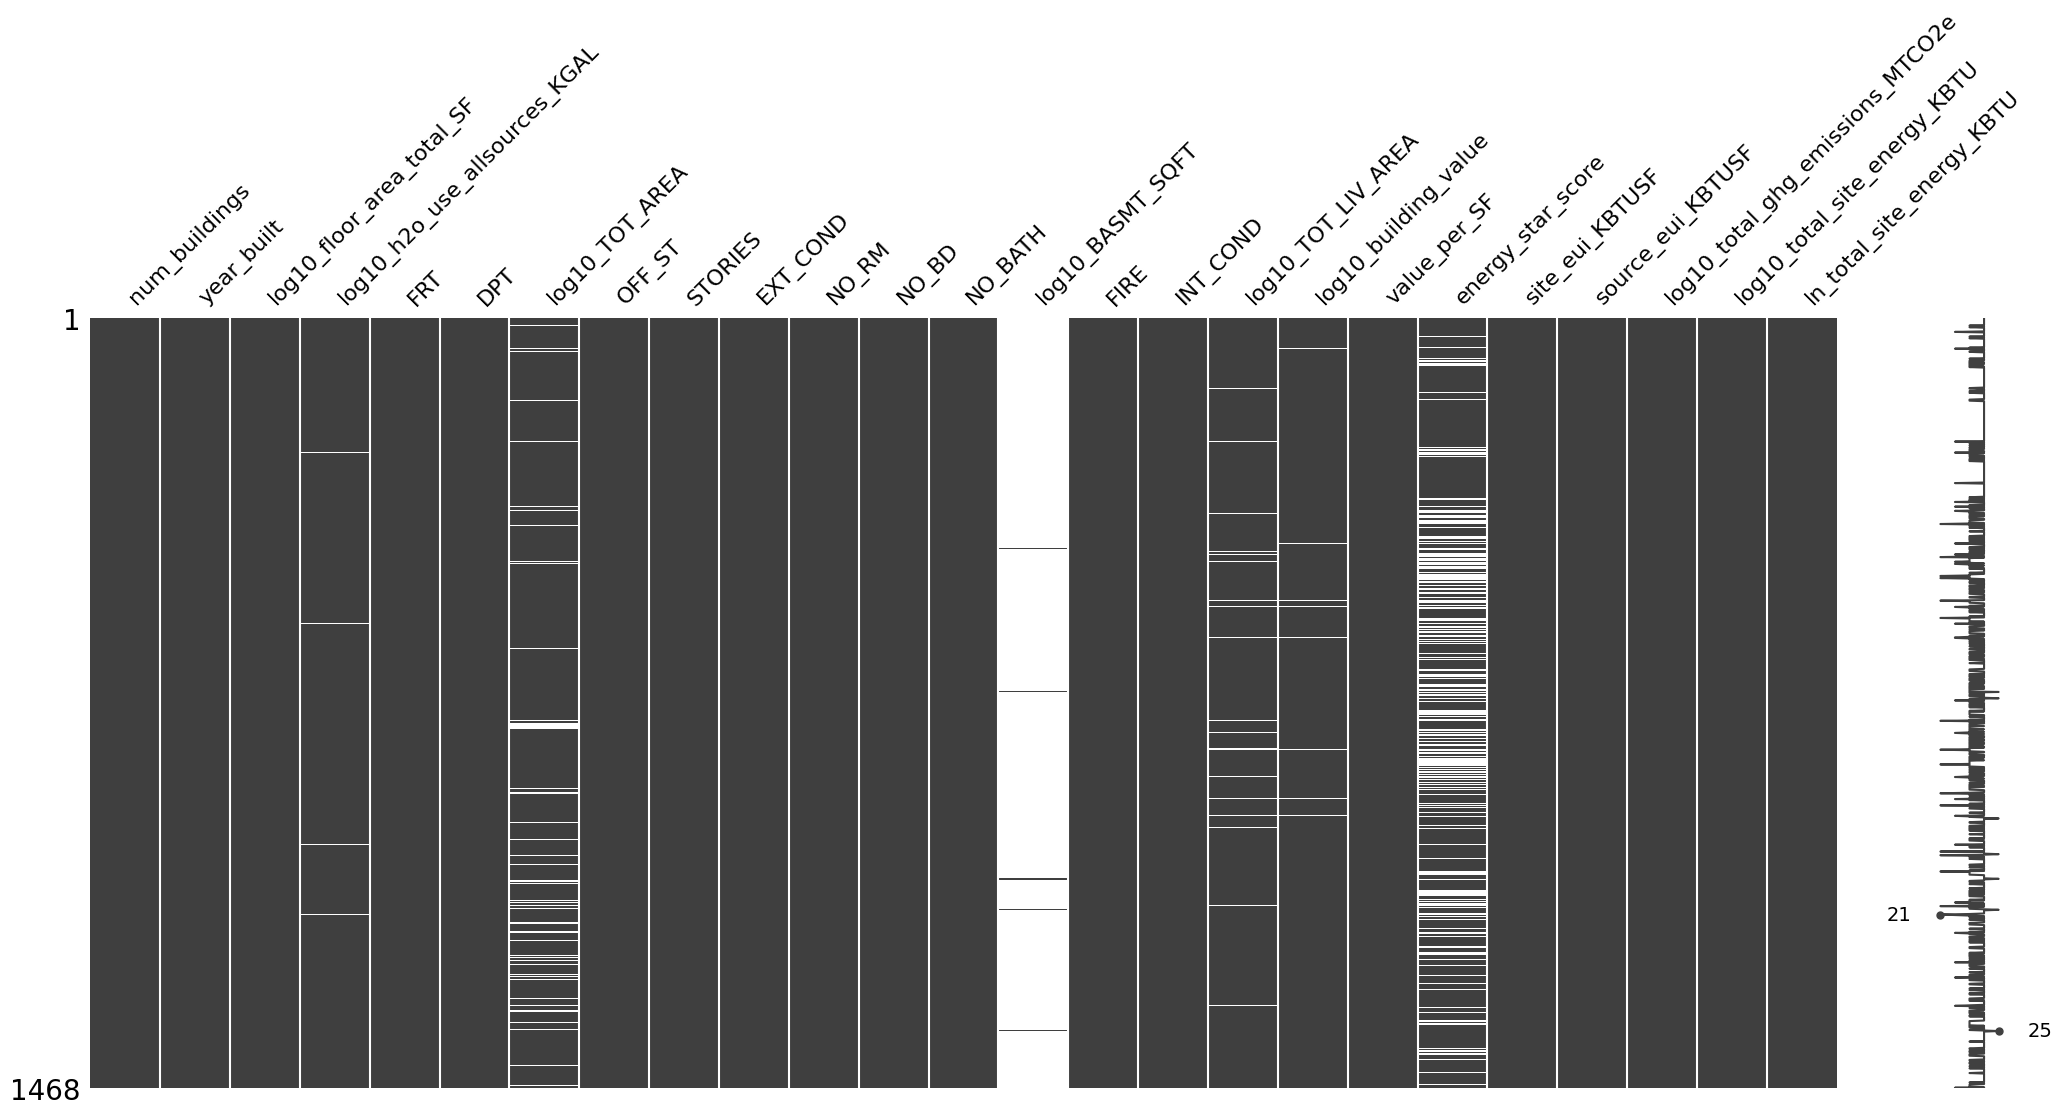

In [40]:
msno.matrix(X_numeric_data)

In [41]:
Xnl = np.vstack((Xn_col, Xn))
Xnl

array([['num_buildings', 'year_built', 'log10_floor_area_total_SF', ...,
        'log10_total_ghg_emissions_MTCO2e',
        'log10_total_site_energy_KBTU', 'ln_total_site_energy_KBTU'],
       [1.0, 1987.0, 6.048234318169059, ..., 3.9289588408808296,
        7.907972884366206, 18.2087804793428],
       [1.0, 1992.0, 6.06028449748612, ..., 3.9053208639835395,
        7.869170364845932, 18.1194343763248],
       ...,
       [1.0, 1931.0, 5.0753498418576335, ..., 2.40671045860979,
        6.363151571787859, 14.6516979536604],
       [1.0, 1959.0, 5.365487984890899, ..., 3.3519508325993845,
        7.439206335237023, 17.1294056112236],
       [7.0, 2010.0, 5.647454368518243, ..., 3.1977766112713866,
        7.138816062352515, 16.4377314467994]], dtype=object)

## TASK 2.3 Impute missing categorial variables
you will have to remove Nan values and replace them.

You can use `sklearn.impute.SimpleImputer using strategy="most_frequent"` on all variables, but you will have a naif solution for numerical imputations

I prefer to replace them with "None" or a similar string, for which you can use the fillna method: ```df.fillna("None")``` and leave it at that or with a little more effort you can input values based on nearest neighbors or some other inputation scheme. any choice goes so long as it is well described and justified with words.

<Axes: >

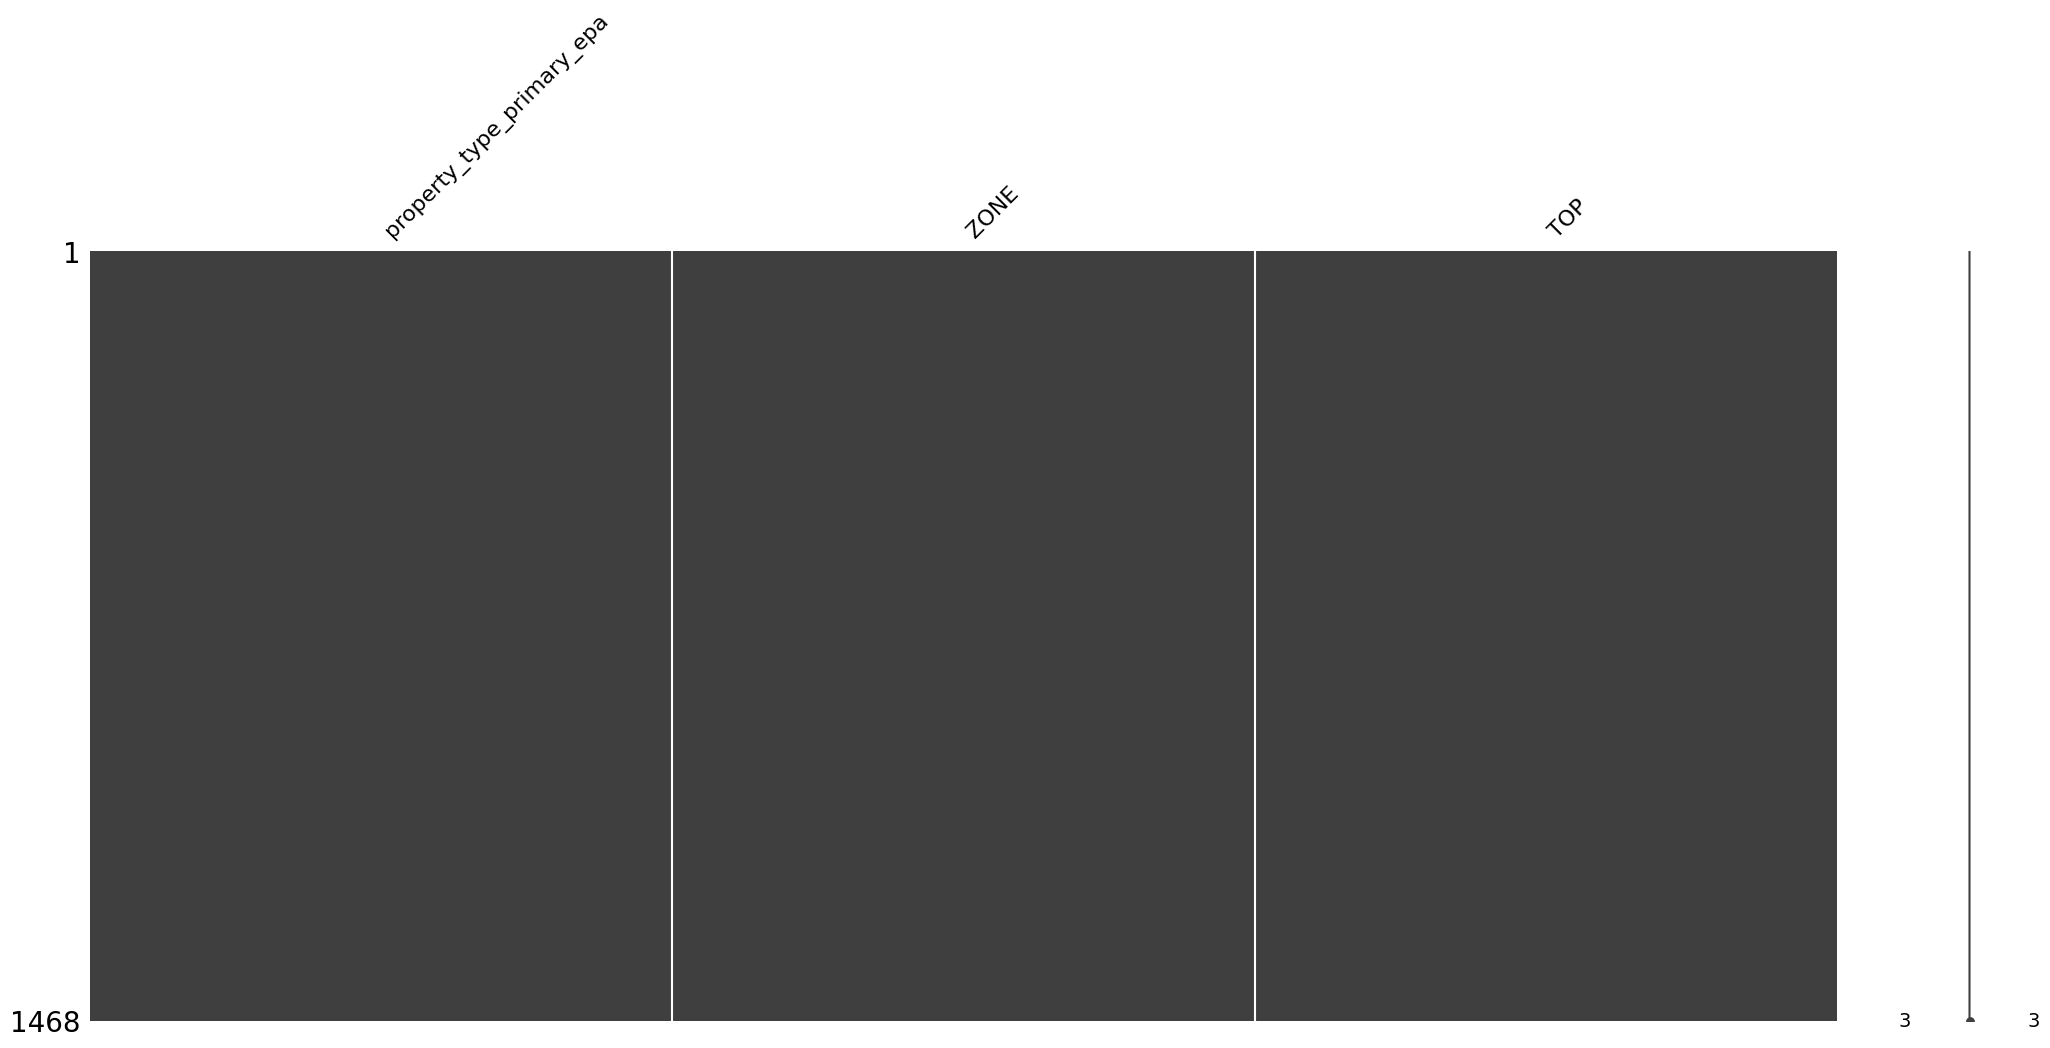

In [42]:
X_categorical_data = X_categorical_data.fillna("None")
msno.matrix(X_categorical_data)

# TASK 3 One Hot Encode the Categorical Variables

Hint: Once you have done the fit and the transformation, which gives you the transformed data according to the new encoding, what you get is normally a sparse matrix. In principle there is an argument `sparse` to `OneHotEncoder` which should prevent this and give you a dense matrix, which is much easier to handle (consider asking me or looking up what is a sparse matrix!). That attribute did not work for me so once I applied the new encoding I converted the result to a dense matrix as
`Xc = Xc.todense()`

Finally, you will need to use a specific method to get the new names of the variables. Its a method of your model (which I called ohe below) and you can find it in this page here https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [43]:
X_categorical_data.describe()

,property_type_primary_epa,ZONE,TOP
count,1468,1468,1468
unique,57,33,2
top,Multifamily Housing,I2,F
freq,391,225,1423


In [44]:
from sklearn.preprocessing import OneHotEncoder
# DELETE
#your code here

ohe = OneHotEncoder() #replace ... with your code

Xc = ohe.fit_transform(X_categorical_data)

Xc.shape

(1468, 92)

In [45]:
# there is a speific method of ohe that allows you to get the names of the features after the encoding is done
feature_name_cat = ohe.get_feature_names_out() #replace ... with your code
feature_name_cat

array(['property_type_primary_epa_Adult Education',
       'property_type_primary_epa_Ambulatory Surgical Center',
       'property_type_primary_epa_Automobile Dealership',
       'property_type_primary_epa_College/University',
       'property_type_primary_epa_Convention Center',
       'property_type_primary_epa_Courthouse',
       'property_type_primary_epa_Data Center',
       'property_type_primary_epa_Distribution Center',
       'property_type_primary_epa_Drinking Water Treatment & Distribution',
       'property_type_primary_epa_Enclosed Mall',
       'property_type_primary_epa_Financial Office',
       'property_type_primary_epa_Fitness Center/Health Club/Gym',
       'property_type_primary_epa_Food Sales',
       'property_type_primary_epa_Food Service',
       'property_type_primary_epa_Hospital (General Medical & Surgical)',
       'property_type_primary_epa_Hotel',
       'property_type_primary_epa_Ice/Curling Rink',
       'property_type_primary_epa_K-12 School',
       '

In [46]:
fnc = pd.Index(np.hstack(feature_name_cat))
Xcl = np.vstack((fnc, Xc.asformat("array")))
Xcl.shape

(1469, 92)

# Task 4 recombine your numerical and categorical imput features and split your data into training and testing

In [47]:
# this dont need to be the same for you
Xn.shape

(1468, 25)

In [48]:
# this dont need to be the same for you
Xc.shape

(1468, 92)

In [49]:
'''Xc = Xc.todense()
X = np.hstack([Xn, Xc])
X.shape'''

Xc = Xc.todense()
X = np.hstack([Xn, Xc])
Xl = np.hstack([Xnl, Xcl])
X.shape

(1468, 117)

In [50]:
print("The dataset has {} features (!!!)".format(X.shape[1]))

The dataset has 117 features (!!!)


In [51]:
X = pd.DataFrame(X)
Xl = pd.DataFrame(Xl)
Xl_col = Xl.columns

In [52]:
# make a train and test dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [53]:
'''X_train = np.asarray(X_train)
X_test = np.asarray(X_test)'''

'X_train = np.asarray(X_train)\nX_test = np.asarray(X_test)'

# TASK 5 run a random forest REGRESSION model

report the score on the tranining and test data and identify the most important features

(hint: if you see "ValueError: Input contains NaN, infinity or a value too large for dtype('float64')." check
1. np.isnan(Xn).sum().sum() and np.isnan(Xc).sum().sum() both return 0
2. np.isinf(Xn).sum().sum() returns 0
3. all the feature that had very large numbers (> 1e5) have been converted to the log of their values

In [54]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=2, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=0)

In [55]:
print ("the model test accuracy is {:.2}".format(rf.score(X_test, y_test)))

the model test accuracy is 0.66


In [56]:
#this is how you see the importance of the features
rf.feature_importances_[:10]

array([8.48387645e-04, 9.39134054e-04, 6.33108533e-02, 3.05449821e-03,
       3.07511031e-03, 0.00000000e+00, 2.10397029e-02, 1.90318293e-03,
       0.00000000e+00, 1.83348435e-05])

In [57]:
tree_feature_importances = rf.feature_importances_

feature_names = Xl_col

len(feature_names)

117

<ipython-input-58-68fce1ca1f52>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


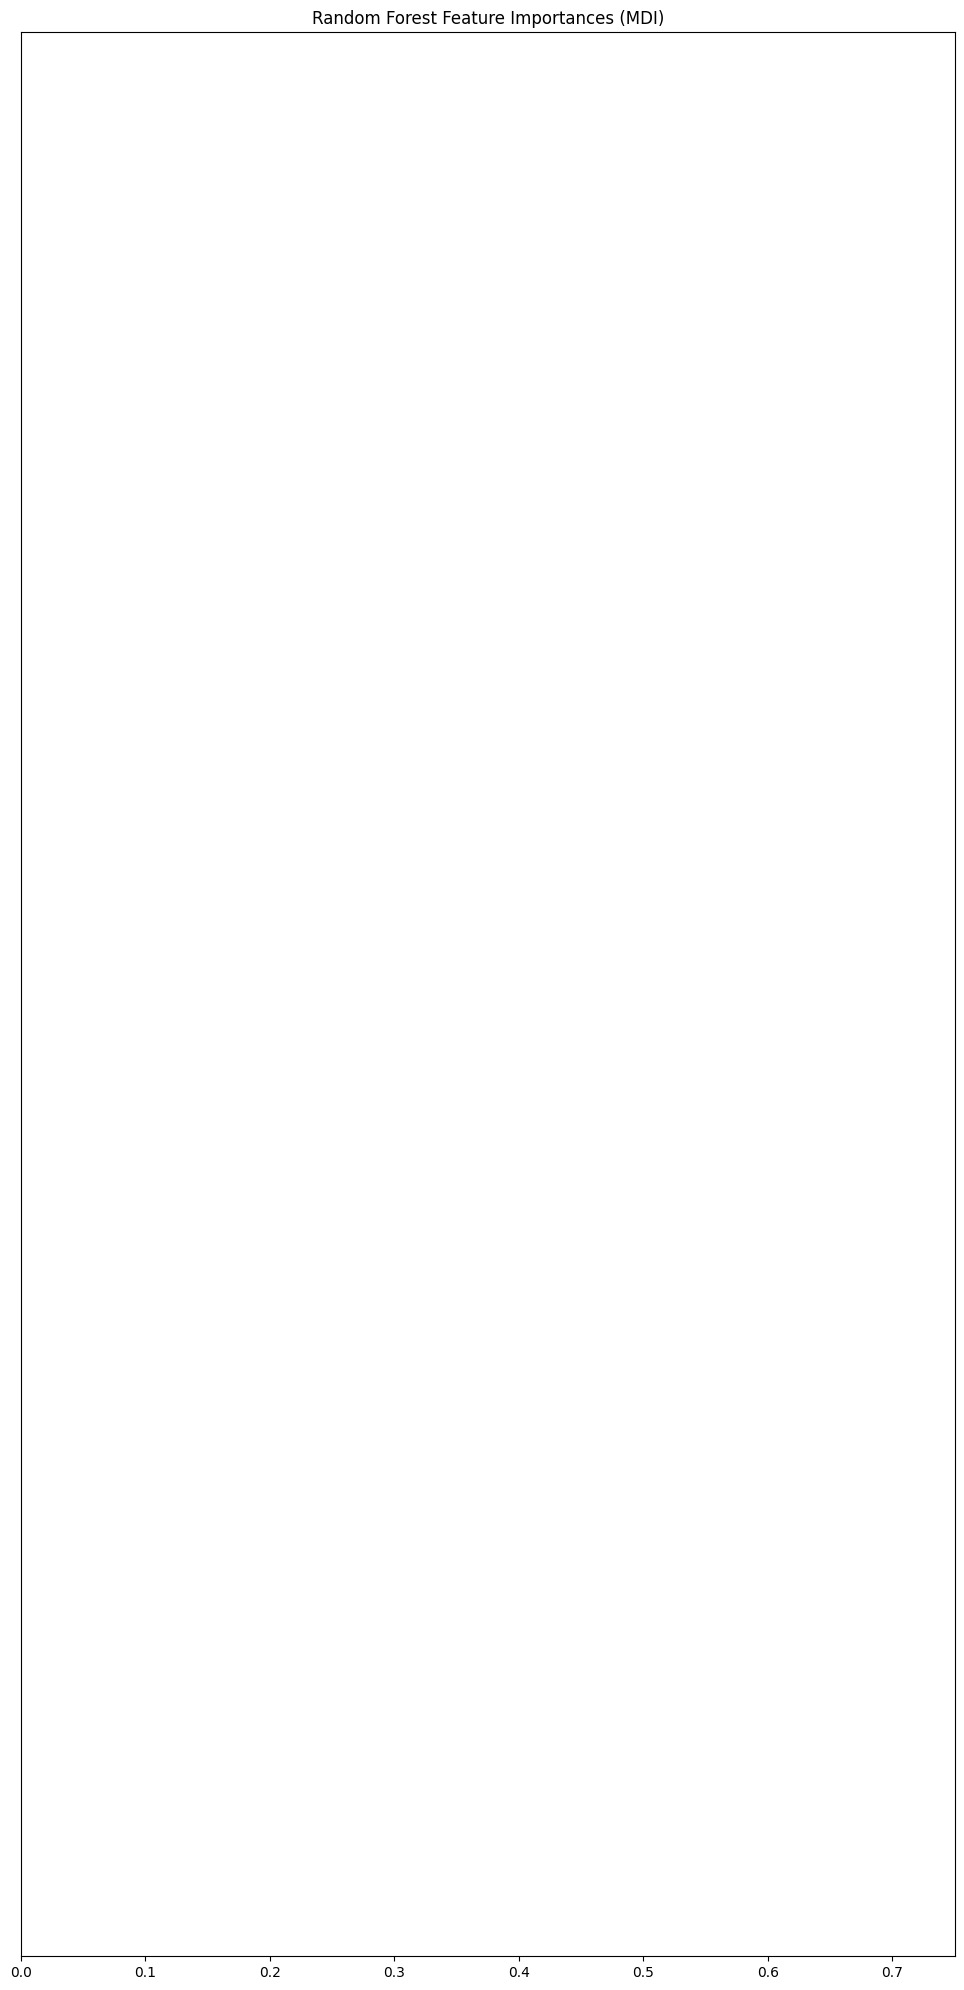

In [58]:
# plot the top ~50 features
import pylab as plt

sorted_idx = np.argsort(tree_feature_importances) #replace ... with your code

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(10,20))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
ax.set_ylim(550, len(feature_names))
plt.show()

#your plot may be different from mine

In [59]:
# CAPTION HERE! How is your model, How is your feature importance results? what can you notice? is it interesting? is it insightful??

# TASK 6 do it for another city! note: the variable names wont be the same


# useful links and methods and functions I used:

```df.dropna()``` to remove observation with missing variables

```df.drop(columns, axis=1)``` to remove features (columns)


```np.log10()``` and ```np.isinf()``` to convert to log space and find infinite values  

`np.hstack([X1, X2])` to concatenate two arrays


one hot encoder https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html and https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/


KNN imputer https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html , https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/, and
https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/  